In [30]:
# data stuff:
import pandas as pd
import numpy as np

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.regression.linear_model import yule_walker

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## The AR Model:

The autoregressive model describes a relationship between past and present states of a variable. It is therefore suitable for variables in which past and present values correlate. It is the most basic of the univariate models.

See page 46 of "Advanced Forecasting with Python".

---

#### Import Data:

In [2]:
earthquakes_df = pd.read_csv('data/earthquakes.csv')
earthquakes_df

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,...,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,...,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,...,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,...,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


In [3]:
# earthquakes_df.profile_report()

#### Convert dates to years:

In [4]:
# check for missing values:
earthquakes_df['Date'].isna().value_counts()

# convert to year:
earthquakes_df['year'] = pd.to_datetime(earthquakes_df['Date'], utc=True).dt.year
earthquakes_df['year']

0        1965
1        1965
2        1965
3        1965
4        1965
         ... 
23407    2016
23408    2016
23409    2016
23410    2016
23411    2016
Name: year, Length: 23412, dtype: int64

#### Filter data to get only the major earthquakes:

In [5]:
# major quakes:
major_quakes_df = earthquakes_df[earthquakes_df['Magnitude'] >= 7]
major_quakes_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,year
11,01/24/1965,00:11:17,-2.608,125.952,Earthquake,20.0,NaN,NaN,8.2,MW,...,NaN,NaN,NaN,NaN,ISCGEM861299,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
16,02/04/1965,05:01:22,51.251,178.715,Earthquake,30.3,NaN,NaN,8.7,MW,...,NaN,NaN,NaN,NaN,OFFICIAL19650204050122_30,OFFICIAL,ISCGEM,OFFICIAL,Automatic,1965
26,02/04/1965,08:40:44,51.443,179.605,Earthquake,30.0,NaN,NaN,7.3,MW,...,NaN,NaN,NaN,NaN,ISCGEM859264,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
62,02/23/1965,22:11:47,-25.633,-70.679,Earthquake,35.0,NaN,NaN,7.0,MW,...,NaN,NaN,NaN,NaN,ISCGEM860516,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
87,03/14/1965,15:53:07,36.405,70.724,Earthquake,207.8,NaN,NaN,7.4,MW,...,NaN,NaN,NaN,NaN,ISCGEM858598,ISCGEM,ISCGEM,ISCGEM,Automatic,1965


#### Get a count of earquakes per year and plot:

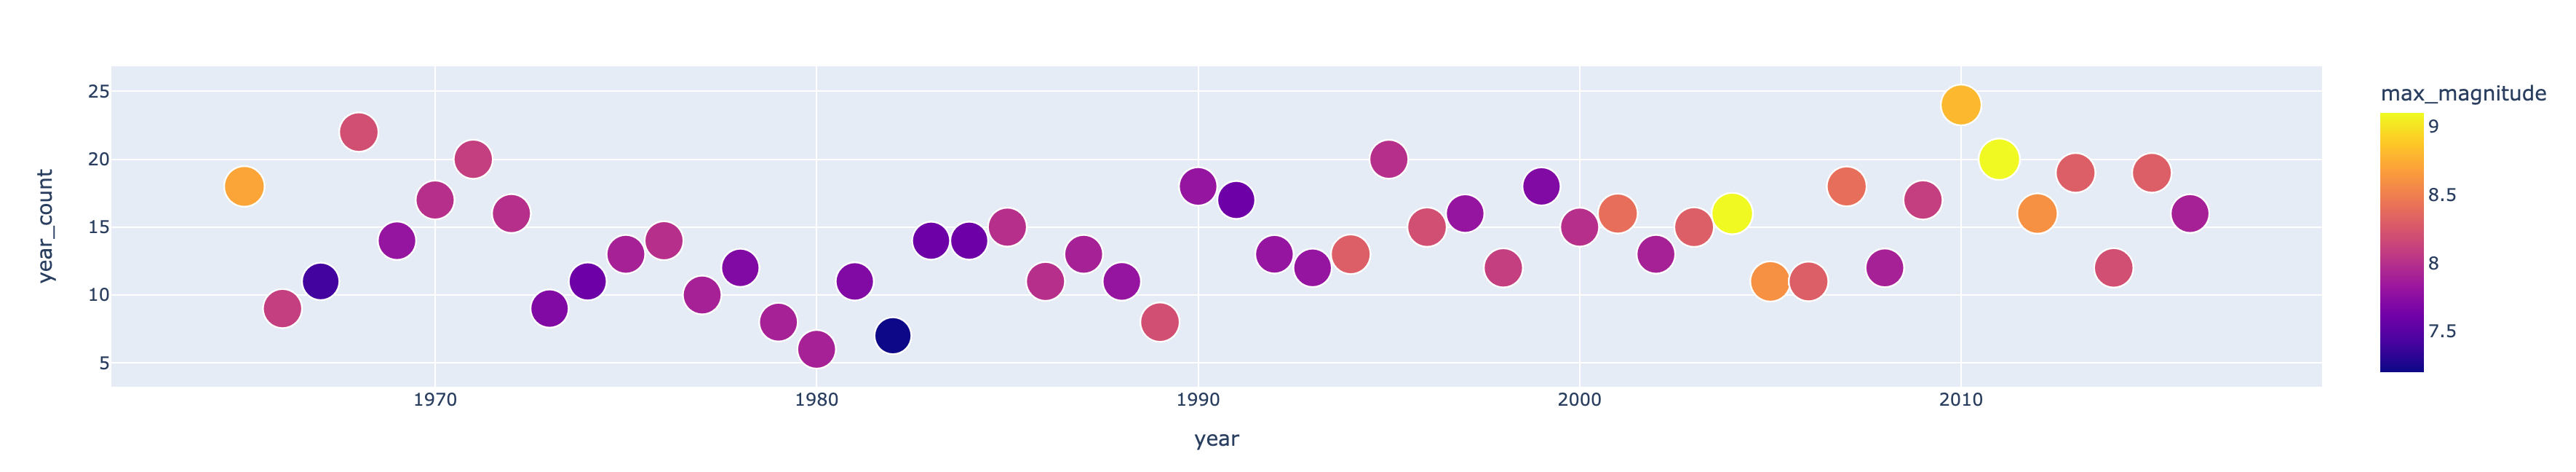

In [35]:
# get a yearly count and maximum magnitude (append it to the original df):
major_quakes_df['year_count'] = major_quakes_df.groupby('year')['Date'].transform('count')
major_quakes_df['max_magnitude'] = major_quakes_df.groupby('year')['Magnitude'].transform('max')


# plot
px.scatter(major_quakes_df, x='year', y='year_count', color='max_magnitude', size='max_magnitude')
Image(filename='./images/ch3_quakesscatter.png', width=1600)

---

<div class="alert alert-block alert-info">
    
#### Extra Credit: 
Below we show that according to the theory, earthquakes display a long-tailed "power law" distribution, with large earthquakes happening with low frequency compared to smaller ones.

In a power-law distribution, the probability of an event is proportional to its size raised to a negative exponent. See Page 90 of "The Model Thinker".
    
</div>

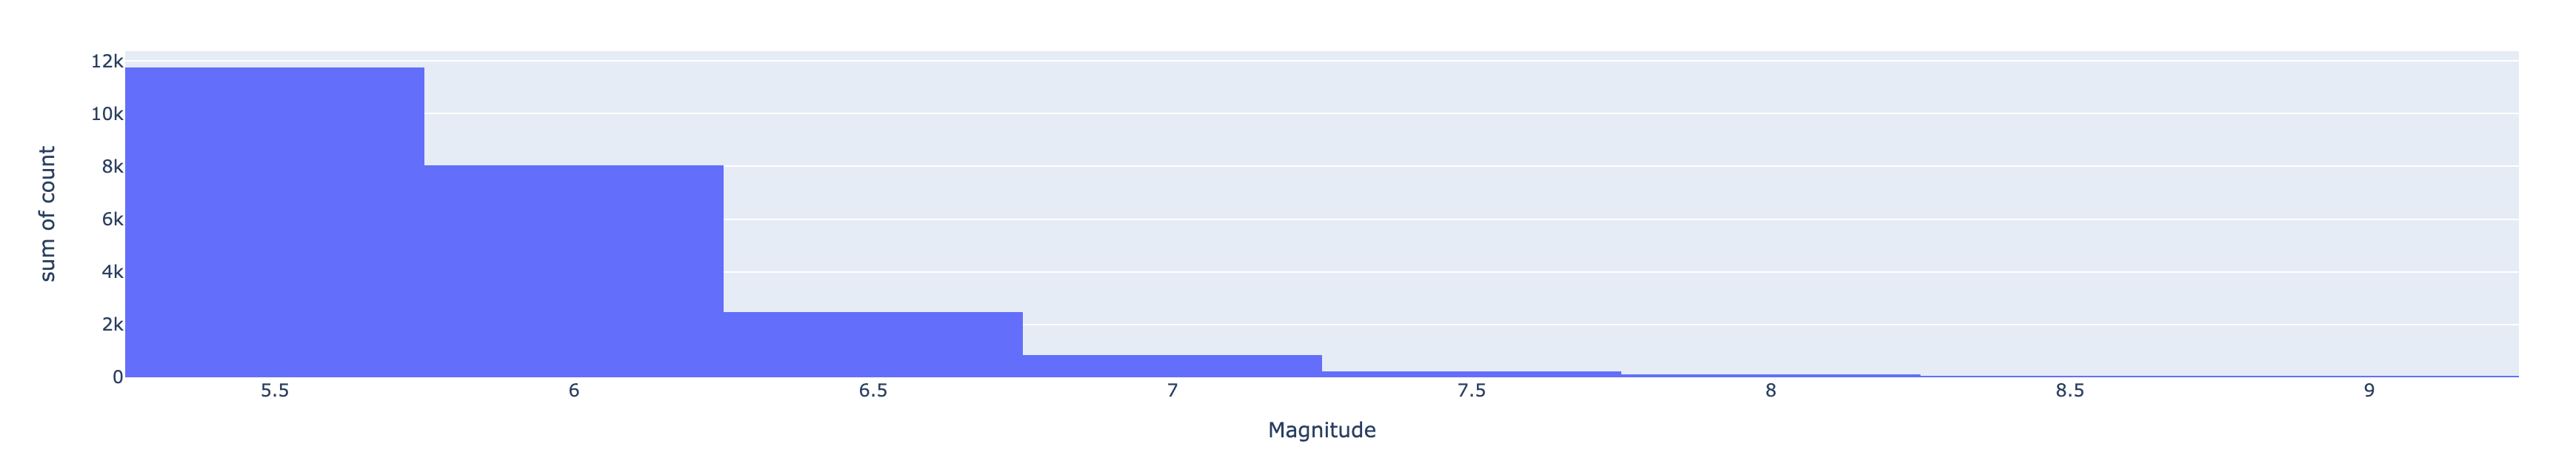

In [36]:
# plot frequency of earthquake magnitudes:
mags = earthquakes_df.groupby('Magnitude')
mags_df = mags['Magnitude'].count().to_frame()
mags_df = mags_df.rename(columns={'Magnitude': 'count'}).reset_index()
# mags_df
px.histogram(mags_df, x='Magnitude', y='count')
Image(filename='./images/ch3_powerlaw.png', width=1600)

---

#### Obtain a simplified dataframe containing the earthquake count per year, and the count for the following year by shifting:

In [8]:
# we get the max since they are all the same value for each year:
eq_per_year = major_quakes_df.groupby('year')['year_count'].max()
eq_per_year_shifted = eq_per_year.shift(1)

# define counts df:
quakes_count_df = pd.DataFrame({'this year': eq_per_year,
                         'last year': eq_per_year_shifted})

# remove nan-values:
quakes_count_df.dropna(axis=0, inplace=True)
quakes_count_df.tail()

,this year,last year
year,,
2012,16,20.0
2013,19,16.0
2014,12,19.0
2015,19,12.0
2016,16,19.0


In [9]:
# remove erroneous values (see page 48 of the text):
quakes_count_df = quakes_count_df.iloc[:-2]
quakes_count_df.tail()

,this year,last year
year,,
2010,24,17.0
2011,20,24.0
2012,16,20.0
2013,19,16.0
2014,12,19.0


#### Obtain autocorrelation values:

In [10]:
quakes_count_df.corr()

,this year,last year
this year,1.000000,0.278248
last year,0.278248,1.000000


As we can see above, the autocorrelation is intermediate and positive. The oscillating nature of the yearly count of earthquakes, however, tell us that it should be negative. **We suspect this could be due to the presence of a trend.**

&nbsp;

---
### Stationarity and the ADF Test:
The "Augmented Dicky-Fuller" test is used to ascertain whether a time-series is stationary or not. Time-series that are stable around the same average are said to be stationary and do not display long-term trends.

See page 52 of "Advanced Forecasting with Python".


**Per Wikipedia:**
In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. The test is named after the statisticians David Dickey and Wayne Fuller, who developed it in 1979

A simple AR(1) model is:
$$y_{t}=\rho y_{t-1}+u_{t}\,$$

where $y_{t}$ is the variable of interest, $t$ is the time index, $\rho$  is a coefficient, and $u_{t}$ is the error term (assumed to be white noise). A unit root is present if $\rho =1$. The model would be non-stationary in this case.

The intuition behind the test is as follows. If the series $y$ is stationary (or trend-stationary), then it has a tendency to return to a constant (or deterministically trending) mean. Therefore, large values will tend to be followed by smaller values (negative changes), and small values by larger values (positive changes). Accordingly, the level of the series will be a significant predictor of next period's change, and will have a negative coefficient. If, on the other hand, the series is integrated, then positive changes and negative changes will occur with probabilities that do not depend on the current level of the series; in a random walk, where you are now does not affect which way you will go next.

Source: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

---

In [11]:
# runs the Dicky-Fuller hypothesis test:
result = adfuller(eq_per_year)

# obtain p-value:
pvalue = result[1]


if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

stationary


Given the results above (p-value << 1), we can conclude that the time-series is stationary.

However, since the series is stationary, we expect the autocorrelation to be negative, which as we have seen, is positive (0.27).

&nbsp;

---
### Differencing a time-series:
At this point in the analysis, we have conflicting indicators: a positive autocorrelation value (trend exists), and ADF test that tells us that the time-series is stationary. Our hypothesis is that this is due to the presence of trends.

Differencing allows us to remove trends by modeling the series on the difference between steps. Although a trend exists in the data, it is likely this will be removed after differencing. To make sure, we will perform the ADF test after differencing.

---

In [12]:
# apply differencing:
quakes_count_df['differenced'] = quakes_count_df['this year'] - quakes_count_df['last year']
quakes_count_df.head()

,this year,last year,differenced
year,,,
1966,9,18.0,-9.0
1967,11,9.0,2.0
1968,22,11.0,11.0
1969,14,22.0,-8.0
1970,17,14.0,3.0


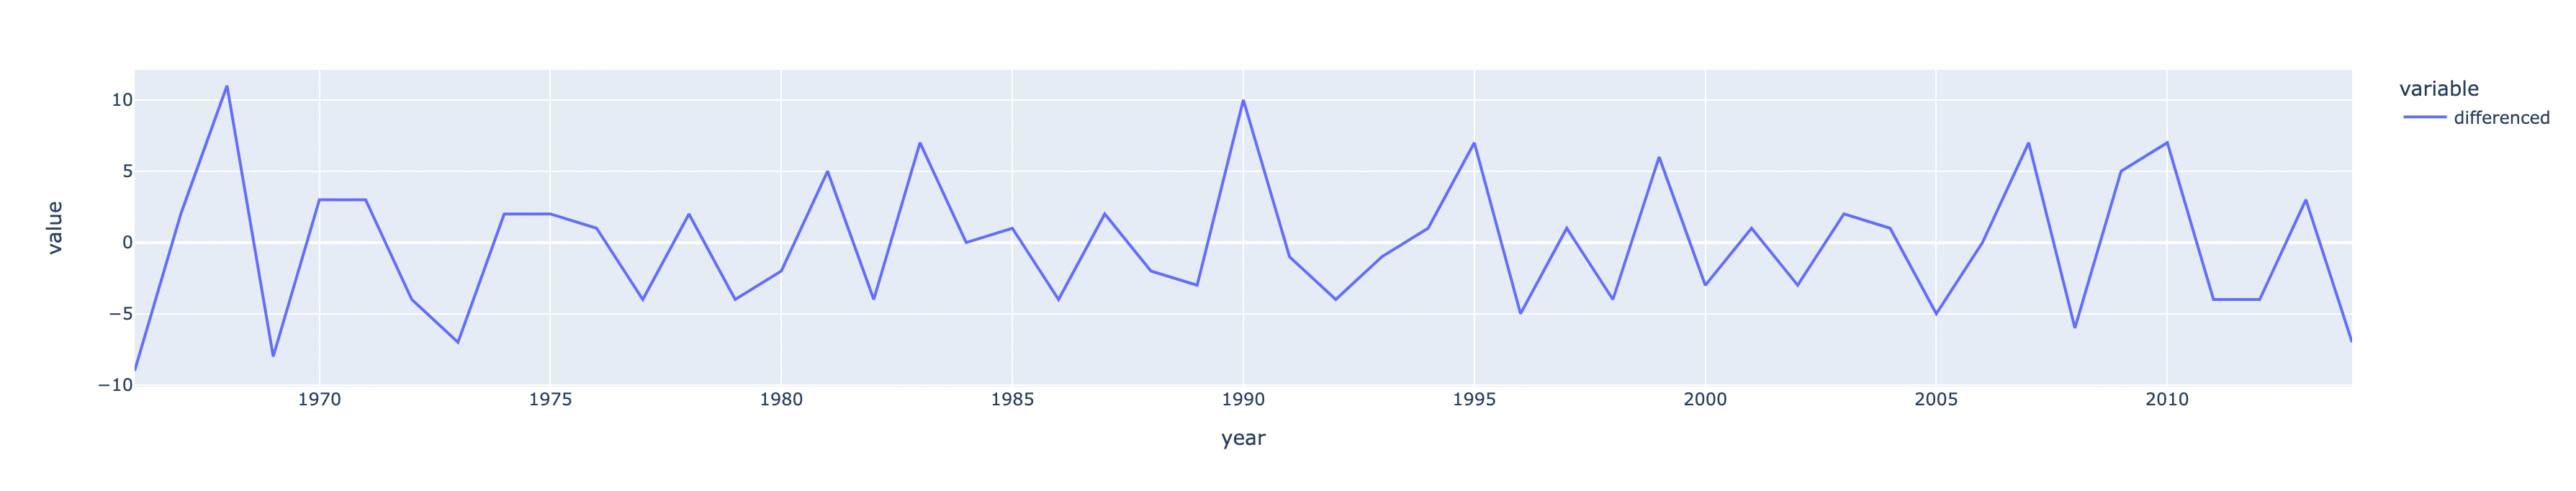

In [38]:
# plot:
px.line(quakes_count_df['differenced'])
Image(filename='./images/ch3_differenced.png', width=1600)

#### Create a new df to compute autocorrelation by using the differenced values against their shited values:

In [14]:
differenced_df = pd.DataFrame({'this year': quakes_count_df['differenced'],
                              'last year': quakes_count_df['differenced'].shift(1)})
differenced_df.dropna(axis=0, inplace=True)
differenced_df.head()

,this year,last year
year,,
1967,2.0,-9.0
1968,11.0,2.0
1969,-8.0,11.0
1970,3.0,-8.0
1971,3.0,3.0


### Compute Autocorrelation:

In [15]:
differenced_df.corr()

,this year,last year
this year,1.000000,-0.378259
last year,-0.378259,1.000000


As we can see above, after differencing, the autocorrelation values are pointing in the right direction.

**A negative value here means that if we have more positive events one year, we expect the next year to have fewer (the opposite).**

&nbsp;

---
### Lags in Autocorrelation:
The number of lags of an autocorralation means how many steps back in time affect the current state of the system.

---

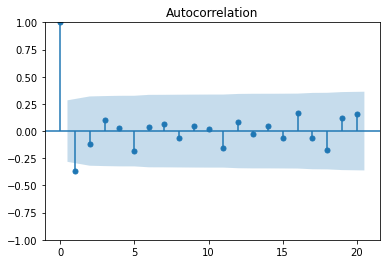

In [16]:
# plot AC function:
plot_acf(differenced_df['this year'], lags=20)

The plot above give us the autocorrelation coefficient on the y-axis, and the number of lags in the x-axis. The coefficient equal 1 at zero, since this is just the original values correlated to themselves. 

In this plot, we should look for values that are at least greater than 0.2 or lower than -0.2 (although it varies in different fields).

The blue area in the graph (the "noise cone") allow you to detect visually which observations are just noise. If the values spike beyond the cone, then this points to a significant autocorrelation value. Generally, larger spiked are more common closer to the y-axis (small lags).

As we can see, the only spike happens at lag-1, which is what we computed before (-0.38). This means that in order to understand what will happen this year, we need only to see what happened last year. For our use case, that means that if we had many earthquales last year, we will have fewer ones this year, and vice-versa.

&nbsp;

---
### Partial Autocorrelation:
In general, a partial correlation is a conditional correlation. It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables. For instance, consider a regression context in which $y$ is the response variable and $x_1$, $x_2$, and $x_3$ are predictor variables. The partial correlation between $y$ and $x_3$ is the correlation between the variables determined taking into account how both $y$ and $x_3$ are related to $x_1$ and $x_2$.

In regression, this partial correlation could be found by correlating the residuals from two different regressions:

1. Regression in which we predict $y$ from $x_1$ and $x_2$,

2. regression in which we predict $x_3$ from $x_1$ and $x_2$. Basically, we correlate the “parts” of $y$ and $x_3$ that are not predicted by $x_1$ and $x_2$.

**Note!**
That this is also how the parameters of a regression model are interpreted. Think about the difference between interpreting the regression models:

$$ y = \beta_0 + \beta_1 x^2 ,$$   $$y = \beta_0 + \beta_1 x + \beta_1 x^2$$ 

In the first model, $\beta_1$ can be interpreted as the linear dependency between $x^2$ and $y$. In the second model, $\beta_2$ would be interpreted as the linear dependency between $x_2$ and $y$ WITH the dependency between $x$ and $y$ already accounted for.

Source: https://online.stat.psu.edu/stat510/lesson/2/2.2

---

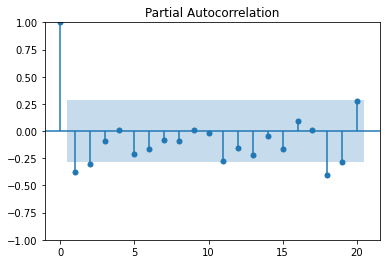

In [17]:
# plot partial autocorrelation function (PACF)
plot_pacf(differenced_df['this year'], lags=20)

Theoretically, once can base the order of the $AR(p)$ time-series based on the PACF function. The theory tells us to take the number of lags before obtaining an autocorrelation value of zero, which in the example above would equal to 3. Thus, we have an $AR(3)$ model as follows:
$$x_t = \beta_1 x_{t-1} + \beta_2 x_{t-2} + \beta_3 x_{t-3} + \epsilon_t$$

---
### Estimating the regression coefficients with the Yule-Walker method (order 3):

---

In [18]:
coefficients, sigma = yule_walker(differenced_df['this year'], order = 3)
print('coefficients: ', -coefficients)
print('sigma: ', sigma)

coefficients:  [0.51636104 0.34981679 0.08922855]
sigma:  3.99051873543974


---
### Forecating values using the obtained coefficients:

---

In [19]:
def get_forecast(original_series, differenced_series, order, num_steps):
    # run Yule-Walker estimate:
    coefficients, sigma = yule_walker(differenced_series, order = order)
    
    # obtaint the differenced values and append to a list:
    val_list = list(differenced_series)

    # reverse the order so that we perform the calculations with the year
    # in descending order (present):
    val_list.reverse()

    # define the number of years to predict:
    num_steps = num_steps

    # itearte thorugh number of steps:
    for step in range(num_steps):
        new_val = 0

        # compute the new values as the sum of lagged values times their coefficient.
        # for order 3 --> future_val = present*x_0 + (present-1)*x_1 + (present-2)*x_2
        for i in range(len(coefficients)):
            new_val += coefficients[i]*val_list[i]

        # insert new value at the beginning of the list:
        val_list.insert(0, new_val)

    # reverse the list to put the items back into the original ascending order:
    val_list.reverse()
    
    # get the index of the original series and construct the index for the predicted series:
    orig_index = list(original_series.index)
    new_index = list(range(orig_index[0], orig_index[-1] + num_steps + 1))

    # add the first original value back into the list and perform a cumulative sum to undo the differencing:
    # (we dropped this value when we differenced the series as it was na after the diff)
    val_list = [original_series.values[0]] + val_list
    final_vals = pd.Series(val_list, index=new_index).cumsum()
    
    # plot the original vs the predicted:
    fig = go.Figure()
    # original
    fig.add_trace(go.Scatter(x=orig_index, y=original_series,
                        mode='lines',
                        name='original'))
    
    # predicted:
    fig.add_trace(go.Scatter(x=new_index, y=final_vals,
                        mode='markers',
                        name='prediction'))
    
    return fig, final_vals

#### Obtain forecast for order 3 and 10 steps:

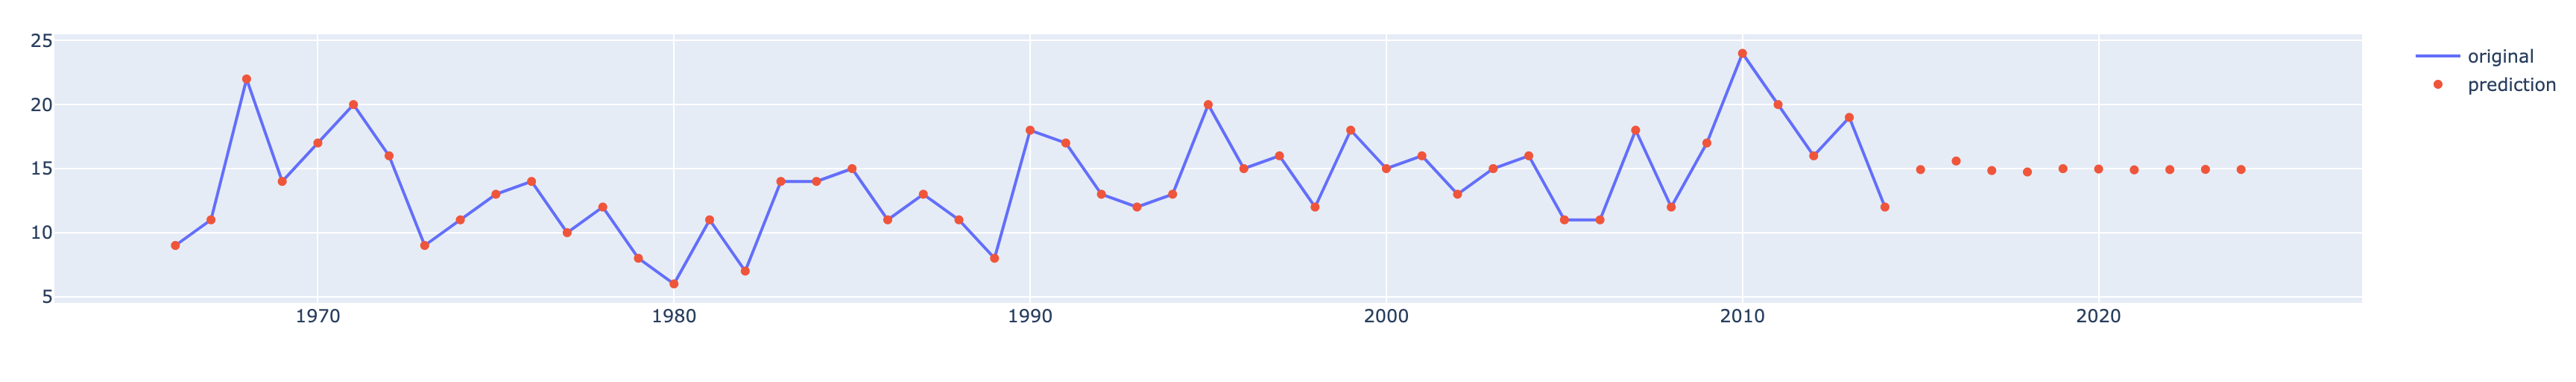

In [39]:
fig, preds = get_forecast(original_series=quakes_count_df['this year'],
                          differenced_series=differenced_df['this year'],
                          order=3,
                          num_steps=10)
fig
Image(filename='./images/ch3_o3preds.png', width=1600)

#### Obtain forecast for order 20 and 10 steps:

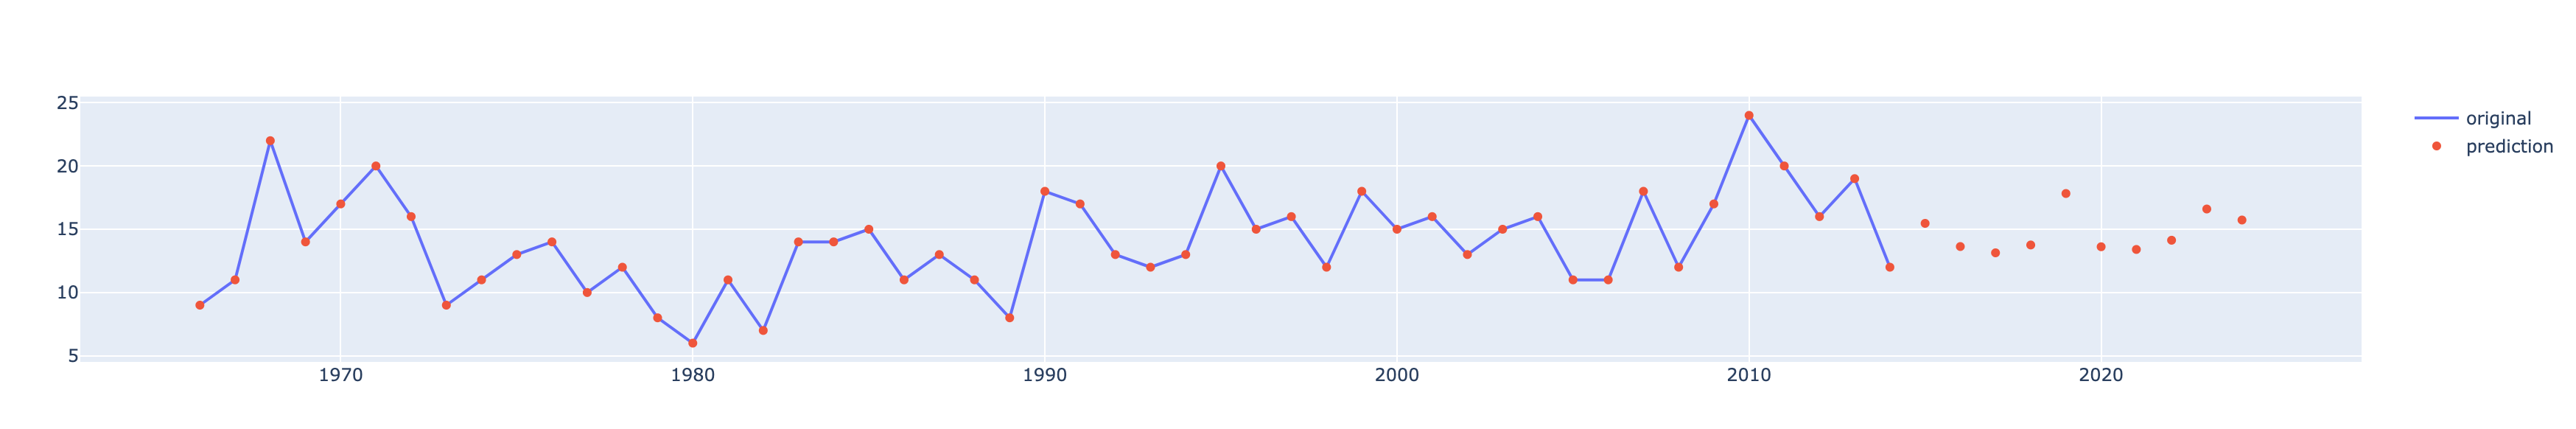

In [40]:
fig, preds = get_forecast(original_series=quakes_count_df['this year'],
                          differenced_series=differenced_df['this year'],
                          order=20,
                          num_steps=10)
fig
Image(filename='./images/ch3_o20preds.png', width=1600)

---
### Fit and Evaluate the model:

---

In [22]:
train = differenced_df['this year'][:-10]
test = quakes_count_df['this year'][-10:]
orig_train = quakes_count_df['this year'][:-10]

In [26]:
fig, preds = get_forecast(original_series=orig_train,
                          differenced_series=train,
                          order=3,
                          num_steps=10)
print('Test R2:', r2_score(test, preds[-10:]))

Test R2: -0.040346700807336155


As we can see above, the order 3 model is pretty bad, giving us a negative R-squared value. Below we will implement a grid search technique to look for the optimal number of lags.

&nbsp;

#### Implement Grid search:

In [25]:
# define arrays to hold the params:
orders = []
r2scores = []

# iterate thorugh values:
for order in range(1, 30):
    # get predictions:
    _, preds = get_forecast(original_series=orig_train,
                          differenced_series=train,
                          order=order,
                          num_steps=10)
    # get score and append:
    score = r2_score(test, np.round(preds[-10:]))
    orders.append(order)
    r2scores.append(score)
    
# Create a results data frame
results = pd.DataFrame({'orders': orders,
                      'scores': r2scores})

# Show the order with best R2 score
results[results['scores'] == results.max()['scores']]

,orders,scores
18,19,0.147727


**Note:** the best we can do is an R-squared value of 0.14 (for an order 19 model), which means the model can only explain 14% of the variation found in the data. 

<div class="alert alert-block alert-warning">
The AR model is one of the basic buiding blocks of univariate time-series. However, it can be used as a standalone only very rare and spcific cases.
</div>